In [1]:
import pickle
import bson
import pandas as pd
import pandas as pd
import numpy as np
import os
import pickle
from bson.objectid import ObjectId
from collections import defaultdict
import timeit
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import datetime


pd.set_option('display.max_columns', None)

In [2]:
dir = "D:/Fall 2023/6748 Practicum/"
processed_data_path = os.path.join(dir,"processed_data")

In [3]:
os.listdir(processed_data_path)

['features.csv', 'X_2P.csv', 'X_3P.csv', 'y_2P.csv', 'y_3P.csv']

In [4]:
df_X_2P = pd.read_csv(os.path.join(processed_data_path,"X_2P.csv"))
df_y_2P = pd.read_csv(os.path.join(processed_data_path,"y_2P.csv"))
df_X_3P = pd.read_csv(os.path.join(processed_data_path,"X_3P.csv"))
df_y_3P = pd.read_csv(os.path.join(processed_data_path,"y_3P.csv"))


In [5]:
df_X_2P.shape,df_y_2P.shape,df_X_3P.shape,df_y_3P.shape,df_y_3P.shape[0]+df_y_2P.shape[0]

((436328, 341), (436328, 1), (261971, 235), (261971, 1), 698299)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
def preprocess_X(X):
    all_columns = set(X.columns.to_list())
    numeric_cols = set(X.select_dtypes(include='number').columns.to_list())
    object_columns = set(X.select_dtypes(include='object').columns.to_list())
    bool_columns = all_columns - numeric_cols - object_columns
    X_cat = X[list(object_columns)]
    X_bool = X[list(bool_columns)].astype('int64')
    X_num = X[list(numeric_cols)]
    encoder = OneHotEncoder(drop='first')
    X_cat_encoded = encoder.fit_transform(X_cat).toarray()
    # Combine the encoded categorical features with numerical features if needed
    X_combined = np.concatenate((X_num,X_bool, X_cat_encoded), axis=1)
    return X_combined

In [14]:
# all_feature_list = ['Distance', 	'Angle', 	'Zone', 	'x_coordinate', 	'y_coordinate', 	'Period', 	'Time_Seconds', 	'Jumpshot', 	'Red Zone', 	'Floater', 
# 'Second Chance', 	'Layup', 	'Paint', 	'Drive', 	'ATO', 	'Off Turnover', 	'Off Steal', 	'Hook Shot', 	'Fastbreak', 	'Pullup', 
# 'Turnaround', 	'Dunk', 	'Step Back', 	'Location', 	'w_l_ratio_last_10', 	'opp_w_l_ratio_last_10', 	'w_l_ratio_last_5', 	'opp_w_l_ratio_last_5', 	'w_l_ratio_last_3', 	'opp_w_l_ratio_last_3', 
# 'w_l_ratio_last_1', 	'opp_w_l_ratio_last_1', 	'time_seconds', 	'clutch_time', 	'num_blockers_on_team', 	'last_1_game_usage_ratio', 	'last_3_game_usage_ratio', 	'last_5_game_usage_ratio', 	'last_10_game_usage_ratio', 	'Big', 
# 'Mid', 	'Small', 	'height', 	'LBA_position', 	'year', 	'games played since', 	'L1 2PM', 	'L1 2PA', 	'L1 2P%', 	'L1 Dunks made', 
# 'L1 Dunks attempted', 	'L1 Dunk FG%', 	'L1 Layups made', 	'L1 Layups attempted', 	'L1 Layup FG%', 	'L1 Floaters made', 	'L1 Floaters attempted', 	'L1 Floater FG%', 	'L1 Hook Shots made', 	'L1 Hook Shots attempted', 
# 'L1 Hook Shot FG%', 	'L1 Jumpshots made', 	'L1 Jumpshots attempted', 	'L1 Jumpshots FG%', 	'L1 Pullups made', 	'L1 Pullups attempted', 	'L1 Pullup FG%', 	'L1 Turnarounds made', 	'L1 Turnarounds attempted', 	'L1 Turnaround FG%', 
# 'L1 Step Backs made', 	'L1 Step Backs attempted', 	'L1 Step Back FG%', 	'L1 Jumpshots assisted on', 	'L1 Jumpshots assisted%', 	'L1 1 made', 	'L1 2-1 made', 	'L1 2-2 made', 	'L1 2-3 made', 	'L1 3-1 made', 
# 'L1 3-2 made', 	'L1 3-3 made', 	'L1 4-1 made', 	'L1 4-2 made', 	'L1 4-3 made', 	'L1 1 attempted', 	'L1 2-1 attempted', 	'L1 2-2 attempted', 	'L1 2-3 attempted', 	'L1 3-1 attempted', 
# 'L1 3-2 attempted', 	'L1 3-3 attempted', 	'L1 4-1 attempted', 	'L1 4-2 attempted', 	'L1 zone 1 FG%', 	'L1 zone 2-1 FG%', 	'L1 zone 2-2 FG%', 	'L1 zone 2-3 FG%', 	'L1 zone 3-1 FG%', 	'L1 zone 3-2 FG%', 
# 'L1 zone 3-3 FG%', 	'L1 zone 4-1 FG%', 	'L1 zone 4-2 FG%', 	'L1 zone 4-3 FG%', 	'L1 4-3 attempted', 	'L3 2PM', 	'L3 2PA', 	'L3 2P%', 	'L3 Dunks made', 	'L3 Dunks attempted', 
# 'L3 Dunk FG%', 	'L3 Layups made', 	'L3 Layups attempted', 	'L3 Layup FG%', 	'L3 Floaters made', 	'L3 Floaters attempted', 	'L3 Floater FG%', 	'L3 Hook Shots made', 	'L3 Hook Shots attempted', 	'L3 Hook Shot FG%', 
# 'L3 Jumpshots made', 	'L3 Jumpshots attempted', 	'L3 Jumpshots FG%', 	'L3 Pullups made', 	'L3 Pullups attempted', 	'L3 Pullup FG%', 	'L3 Turnarounds made', 	'L3 Turnarounds attempted', 	'L3 Turnaround FG%', 	'L3 Step Backs made', 
# 'L3 Step Backs attempted', 	'L3 Step Back FG%', 	'L3 Jumpshots assisted on', 	'L3 Jumpshots assisted%', 	'L3 1 made', 	'L3 2-1 made', 	'L3 2-2 made', 	'L3 2-3 made', 	'L3 3-1 made', 	'L3 3-2 made', 
# 'L3 3-3 made', 	'L3 4-1 made', 	'L3 4-2 made', 	'L3 4-3 made', 	'L3 1 attempted', 	'L3 2-1 attempted', 	'L3 2-2 attempted', 	'L3 2-3 attempted', 	'L3 3-1 attempted', 	'L3 3-2 attempted', 
# 'L3 3-3 attempted', 	'L3 4-1 attempted', 	'L3 4-2 attempted', 	'L3 zone 1 FG%', 	'L3 zone 2-1 FG%', 	'L3 zone 2-2 FG%', 	'L3 zone 2-3 FG%', 	'L3 zone 3-1 FG%', 	'L3 zone 3-2 FG%', 	'L3 zone 3-3 FG%', 
# 'L3 zone 4-1 FG%', 	'L3 zone 4-2 FG%', 	'L3 zone 4-3 FG%', 	'L3 4-3 attempted', 	'L5 2PM', 	'L5 2PA', 	'L5 2P%', 	'L5 Dunks made', 	'L5 Dunks attempted', 	'L5 Dunk FG%', 
# 'L5 Layups made', 	'L5 Layups attempted', 	'L5 Layup FG%', 	'L5 Floaters made', 	'L5 Floaters attempted', 	'L5 Floater FG%', 	'L5 Hook Shots made', 	'L5 Hook Shots attempted', 	'L5 Hook Shot FG%', 	'L5 Jumpshots made', 
# 'L5 Jumpshots attempted', 	'L5 Jumpshots FG%', 	'L5 Pullups made', 	'L5 Pullups attempted', 	'L5 Pullup FG%', 	'L5 Turnarounds made', 	'L5 Turnarounds attempted', 	'L5 Turnaround FG%', 	'L5 Step Backs made', 	'L5 Step Backs attempted', 
# 'L5 Step Back FG%', 	'L5 Jumpshots assisted on', 	'L5 Jumpshots assisted%', 	'L5 1 made', 	'L5 2-1 made', 	'L5 2-2 made', 	'L5 2-3 made', 	'L5 3-1 made', 	'L5 3-2 made', 	'L5 3-3 made', 
# 'L5 4-1 made', 	'L5 4-2 made', 	'L5 4-3 made', 	'L5 1 attempted', 	'L5 2-1 attempted', 	'L5 2-2 attempted', 	'L5 2-3 attempted', 	'L5 3-1 attempted', 	'L5 3-2 attempted', 	'L5 3-3 attempted', 
# 'L5 4-1 attempted', 	'L5 4-2 attempted', 	'L5 zone 1 FG%', 	'L5 zone 2-1 FG%', 	'L5 zone 2-2 FG%', 	'L5 zone 2-3 FG%', 	'L5 zone 3-1 FG%', 	'L5 zone 3-2 FG%', 	'L5 zone 3-3 FG%', 	'L5 zone 4-1 FG%', 
# 'L5 zone 4-2 FG%', 	'L5 zone 4-3 FG%', 	'L5 4-3 attempted', 	'L10 2PM', 	'L10 2PA', 	'L10 2P%', 	'L10 Dunks made', 	'L10 Dunks attempted', 	'L10 Dunk FG%', 	'L10 Layups made', 
# 'L10 Layups attempted', 	'L10 Layup FG%', 	'L10 Floaters made', 	'L10 Floaters attempted', 	'L10 Floater FG%', 	'L10 Hook Shots made', 	'L10 Hook Shots attempted', 	'L10 Hook Shot FG%', 	'L10 Jumpshots made', 	'L10 Jumpshots attempted', 
# 'L10 Jumpshots FG%', 	'L10 Pullups made', 	'L10 Pullups attempted', 	'L10 Pullup FG%', 	'L10 Turnarounds made', 	'L10 Turnarounds attempted', 	'L10 Turnaround FG%', 	'L10 Step Backs made', 	'L10 Step Backs attempted', 	'L10 Step Back FG%', 
# 'L10 Jumpshots assisted on', 	'L10 Jumpshots assisted%', 	'L10 1 made', 	'L10 2-1 made', 	'L10 2-2 made', 	'L10 2-3 made', 	'L10 3-1 made', 	'L10 3-2 made', 	'L10 3-3 made', 	'L10 4-1 made', 
# 'L10 4-2 made', 	'L10 4-3 made', 	'L10 1 attempted', 	'L10 2-1 attempted', 	'L10 2-2 attempted', 	'L10 2-3 attempted', 	'L10 3-1 attempted', 	'L10 3-2 attempted', 	'L10 3-3 attempted', 	'L10 4-1 attempted', 
# 'L10 4-2 attempted', 	'L10 zone 1 FG%', 	'L10 zone 2-1 FG%', 	'L10 zone 2-2 FG%', 	'L10 zone 2-3 FG%', 	'L10 zone 3-1 FG%', 	'L10 zone 3-2 FG%', 	'L10 zone 3-3 FG%', 	'L10 zone 4-1 FG%', 	'L10 zone 4-2 FG%', 
# 'L10 zone 4-3 FG%', 	'L10 4-3 attempted', 	'TOT 2PM', 	'TOT 2PA', 	'TOT 2P%', 	'TOT Dunks made', 	'TOT Dunks attempted', 	'TOT Dunk FG%', 	'TOT Layups made', 	'TOT Layups attempted', 
# 'TOT Layup FG%', 	'TOT Floaters made', 	'TOT Floaters attempted', 	'TOT Floater FG%', 	'TOT Hook Shots made', 	'TOT Hook Shots attempted', 	'TOT Hook Shot FG%', 	'TOT Jumpshots made', 	'TOT Jumpshots attempted', 	'TOT Jumpshots FG%', 
# 'TOT Pullups made', 	'TOT Pullups attempted', 	'TOT Pullup FG%', 	'TOT Turnarounds made', 	'TOT Turnarounds attempted', 	'TOT Turnaround FG%', 	'TOT Step Backs made', 	'TOT Step Backs attempted', 	'TOT Step Back FG%', 	'TOT Jumpshots assisted on', 
# 'TOT Jumpshots assisted%', 	'TOT 1 made', 	'TOT 2-1 made', 	'TOT 2-2 made', 	'TOT 2-3 made', 	'TOT 3-1 made', 	'TOT 3-2 made', 	'TOT 3-3 made', 	'TOT 4-1 made', 	'TOT 4-2 made', 
# 'TOT 4-3 made', 	'TOT 1 attempted', 	'TOT 2-1 attempted', 	'TOT 2-2 attempted', 	'TOT 2-3 attempted', 	'TOT 3-1 attempted', 	'TOT 3-2 attempted', 	'TOT 3-3 attempted', 	'TOT 4-1 attempted', 	'TOT 4-2 attempted', 
# 'TOT zone 1 FG%', 	'TOT zone 2-1 FG%', 	'TOT zone 2-2 FG%', 	'TOT zone 2-3 FG%', 	'TOT zone 3-1 FG%', 	'TOT zone 3-2 FG%', 	'TOT zone 3-3 FG%', 	'TOT zone 4-1 FG%', 	'TOT zone 4-2 FG%', 	'TOT zone 4-3 FG%', 
# 'TOT 4-3 attempted'] 								


In [11]:
X_train, X_test, y_train, y_test = train_test_split(preprocess_X(df_X_2P), df_y_2P, test_size=0.3, random_state=42)


In [12]:
def run_model(model_name,actual_model):
    model_name, model =model_name,actual_model
    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='binary')
    train_recall = recall_score(y_train, y_train_pred, average='binary')
    train_f1 = f1_score(y_train, y_train_pred, average='binary')
    train_auc_roc = roc_auc_score(y_train, y_train_pred)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='binary')
    test_recall = recall_score(y_test, y_test_pred, average='binary')
    test_f1 = f1_score(y_test, y_test_pred, average='binary')
    test_auc_roc = roc_auc_score(y_test, y_test_pred)

    print("################")
    print(f"Metrics for {model_name}:")
    print("Train Accuracy:", train_accuracy)
    print("Train Precision:", train_precision)
    print("Train Recall:", train_recall)
    print("Train F1 Score:", train_f1)
    print("Train AUC Score:", train_auc_roc)

    print("Test Accuracy:", test_accuracy)
    print("Test Precision:", test_precision)
    print("Test Recall:", test_recall)
    print("Test F1 Score:", test_f1)
    print("Test AUC Score:", test_auc_roc)

## Dropping NANs from dataframe

In [18]:
X_train, X_test, y_train, y_test = train_test_split(preprocess_X(df_X_2P.dropna(axis=1)), df_y_2P, test_size=0.3, random_state=42)

In [19]:
run_model('DecisionTreeClassifier',DecisionTreeClassifier(min_samples_split=100))

################
Metrics for DecisionTreeClassifier:
Train Accuracy: 0.7083413821215405
Train Precision: 0.7244492193495277
Train Recall: 0.6768300233987499
Train F1 Score: 0.6998305079034534
Train AUC Score: 0.7084890896720332
Test Accuracy: 0.6187747805560012
Test Precision: 0.629822357796519
Test Recall: 0.5866087300019751
Test F1 Score: 0.6074479633737669
Test AUC Score: 0.6189574074103299


### -> Decision tree classifier can't handle nans

## Run baseline models with reduced feature set

In [25]:
def get_non_nan_df_cols(X):
    nan_mask = X.isnull().any()
    columns_with_no_nans = nan_mask[~nan_mask].index
    return columns_with_no_nans


In [26]:
get_non_nan_df_cols(df_X_2P)

Index(['Distance', 'Angle', 'Zone', 'x_coordinate', 'y_coordinate', 'Period',
       'Time_Seconds', 'Jumpshot', 'Red Zone', 'Floater', 'Second Chance',
       'Layup', 'Paint', 'Drive', 'ATO', 'Off Turnover', 'Off Steal',
       'Hook Shot', 'Fastbreak', 'Pullup', 'Turnaround', 'Dunk', 'Step Back',
       'Location', 'time_seconds', 'clutch_time', 'num_blockers_on_team',
       'Big', 'Mid', 'Small'],
      dtype='object')

In [27]:
df_X_2P_red = df_X_2P[get_non_nan_df_cols(df_X_2P)]
df_X_3P_red = df_X_3P[get_non_nan_df_cols(df_X_3P)]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(preprocess_X(df_X_2P_red), df_y_2P, test_size=0.3, random_state=42)


In [30]:
run_model('Logistic Regression',LogisticRegression())

c:\Users\saksham\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\saksham\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


################
Metrics for Logistic Regression:
Train Accuracy: 0.6288761054123871
Train Precision: 0.6251381750279472
Train Recall: 0.6524210210719105
Train F1 Score: 0.6384882793812788
Train AUC Score: 0.6287657400724087
Test Accuracy: 0.6288741701617278
Test Precision: 0.6263171006931724
Test Recall: 0.6493261824093347
Test F1 Score: 0.6376141314077699
Test AUC Score: 0.6287580512538375


In [31]:
run_model('Decision Tree n = 1000',DecisionTreeClassifier(min_samples_split=1000))

################
Metrics for Decision Tree n = 1000:
Train Accuracy: 0.6638171228010438
Train Precision: 0.6899142996145354
Train Recall: 0.6007808273641536
Train F1 Score: 0.642269851445135
Train AUC Score: 0.6641126015480259
Test Accuracy: 0.6462921794666117
Test Precision: 0.6713967088740977
Test Recall: 0.5808353211078868
Test F1 Score: 0.6228413163897034
Test AUC Score: 0.6466638191280062


## Correlation plot for EDA of reduced feature set

In [38]:
df_for_cor = df_X_2P_red
df_for_cor['made'] = df_y_2P

E:\AppData\Local\Temp\ipykernel_3916\4149708271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_cor['made'] = df_y_2P


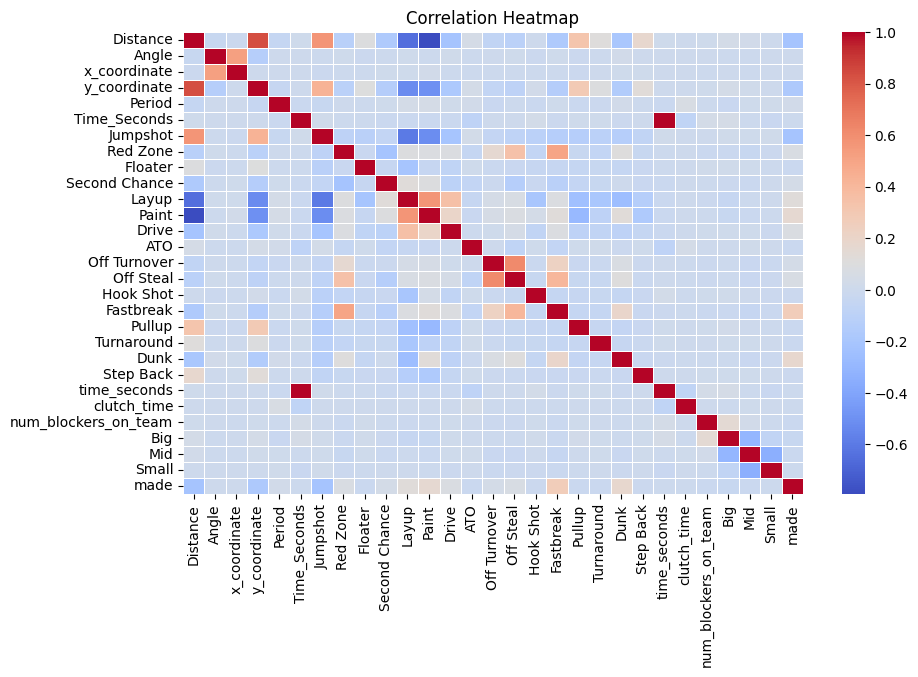

In [39]:
correlation_matrix = df_X_2P_red.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()